In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
import yfinance as yf
import datetime
from sklearn.metrics import mean_squared_error

In [8]:
start = '2012-01-01'
end = datetime.datetime.now().strftime('%Y-%m-%d')
stock = 'AAPL'
# Get the data
df = yf.download(stock, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [9]:
df.reset_index(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,14.621429,14.732143,14.607143,14.686786,12.416982,302220800
1,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.483714,260022000
2,2012-01-05,14.819643,14.948214,14.738214,14.929643,12.622304,271269600
3,2012-01-06,14.991786,15.098214,14.972143,15.085714,12.754257,318292800
4,2012-01-09,15.196429,15.276786,15.048214,15.061786,12.734030,394024400
...,...,...,...,...,...,...,...
3117,2024-05-23,190.979996,191.000000,186.630005,186.880005,186.880005,51005900
3118,2024-05-24,188.820007,190.580002,188.039993,189.979996,189.979996,36294600
3119,2024-05-28,191.509995,193.000000,189.100006,189.990005,189.990005,52280100
3120,2024-05-29,189.610001,192.250000,189.509995,190.289993,190.289993,53068000


In [11]:
ma_100_days = df['Close'].rolling(100).mean()


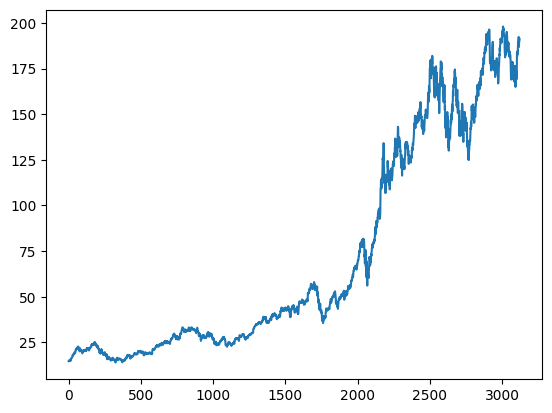

In [12]:
df2 = df.reset_index()['Close']
plt.plot(df2)


In [14]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(3122, 1)

## Training...  ##

In [15]:
train_size = int(len(df2)*0.65)
test_size = len(df2) - train_size
train_data,test_data = df2[0:train_size,:],df2[train_size:len(df2),:1]

In [16]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [17]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [18]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(1928, 100)
[[0.00401431 0.00444289 0.00533302 ... 0.0322774  0.03491288 0.0338967 ]
 [0.00444289 0.00533302 0.00618049 ... 0.03491288 0.0338967  0.03330909]
 [0.00533302 0.00618049 0.00605056 ... 0.0338967  0.03330909 0.03524449]
 ...
 [0.20327156 0.20799565 0.20762914 ... 0.35220252 0.35694022 0.35400802]
 [0.20799565 0.20762914 0.20350234 ... 0.35694022 0.35400802 0.355542  ]
 [0.20762914 0.20350234 0.20824001 ... 0.35400802 0.355542   0.35761896]]
(992, 100)
(992,)


## Creating and fitting LSTM model ##

In [19]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

C:\Users\jestebangil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - loss: 0.0037 - val_loss: 0.0143
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 1.6237e-04 - val_loss: 0.0019
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 7.8797e-05 - val_loss: 0.0027
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 8.0874e-05 - val_loss: 0.0030
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 7.0768e-05 - val_loss: 0.0019
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 7.3013e-05 - val_loss: 0.0026
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 6.3439e-05 - val_loss: 0.0041
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 6.3937e-05 - val_loss: 0.0017
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 5.9252e-05 - val_loss: 0.0042
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 6.4952e-05 - val_loss: 0.0018
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 5.6046e-05 - val_loss: 0.0035
E

In [22]:
model.save('stock_prediction2.h5', save_format = 'h5')

In [36]:
model.compiled_metrics

<keras.src.backend.tensorflow.trainer.TensorFlowTrainer.compiled_metrics.<locals>.DeprecatedCompiledMetric at 0x14b2f5c61e0>

In [27]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [28]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [29]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

0.005560306844601135
0.03135464401905666


## Graph plotting ##

In [30]:
look_back = 100

In [31]:
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [32]:
testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

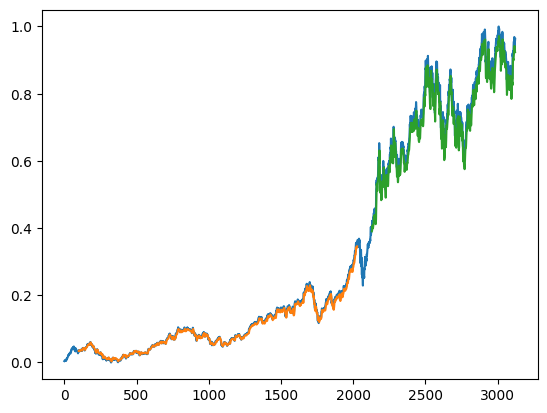

In [33]:
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()